# Master's Thesis Data Project - main analysis

In [66]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from fastparquet import write
import os
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from stargazer.stargazer import Stargazer
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

### Different ways to calculate historical volatility. Function declaration. 
In the analysis I wanted to filter out biases due to different measures of realised volatility. Intraday movements also needed to be captured, as gamma exposure mainly causes intraday autocorrelation. 

In [2]:
#Standard deviation (Close-to-Close)
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result

In [3]:
#Parkinson volatility
def parkinson(price_data, window=30, trading_periods=252, clean=True):
    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0
    
    def f(v):
        return(trading_periods*v.mean())**0.5
    
    result=rs.rolling(window=window, center=False).apply(func=f)
    
    if clean:
        return result.dropna()
    else:
        return result 

In [4]:
#Garman-Klass volatility 
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

### Calling underlying market data. Comptuing log returns, volatility, moving average of the daily volumen. 
data sources: Bloomberg (close prices, volume),YFinance (O,L,H,C). Bloomberg data from downloaded excel files, YFinance from yfinance API. 
Bloomberg data does not contain open, low, high prices --> YFinance, For some indices the volume data from Bloomberg is more accurate, so I merge the two datasets.

In [5]:
#DAX partly prepared in excel 
DAX=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Index/DAX.xlsx')
DAX.set_index('Date', inplace=True)
data=yf.download("^GDAXI", start="2001-01-01", end="2021-01-01")
DAX['sd_vola']=standard_deviation(data)
DAX['parkinson_vola']=parkinson(data)
DAX['gk_vola']=garman_klass(data)

[*********************100%***********************]  1 of 1 completed


In [7]:
BEL20=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Index/BEL20.xlsx')
BEL20['Date'] = pd.to_datetime(BEL20['Date'])
BEL20.set_index('Date', inplace=True)
BEL20['log_ret']=np.log(BEL20['Close']/BEL20['Close'].shift(1))
BEL20['mavg_volume']=BEL20['Volume'].rolling(window=21).mean()
BEL20['sd_vola_252']=BEL20['log_ret'].rolling(window=252).std() * np.sqrt(252)
data=yf.download("^BFX", start="2001-01-01", end="2021-01-01")
BEL20['sd_vola']=standard_deviation(data)
BEL20['parkinson_vola']=parkinson(data)
BEL20['gk_vola']=garman_klass(data)

[*********************100%***********************]  1 of 1 completed


In [12]:
SMI=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Index/SMI.xlsx')
SMI['log_ret']=np.log(SMI['Close']/SMI['Close'].shift(1))
SMI['Date'] = pd.to_datetime(SMI['Date'])
SMI.set_index('Date', inplace=True)
SMI['sd_vola_252']=SMI['log_ret'].rolling(window=252).std() * np.sqrt(252)
SMI['mavg_volume']=SMI['Volume'].rolling(window=21).mean()
data=yf.download("^SSMI", start="2001-01-01", end="2021-01-01")
SMI['sd_vola']=standard_deviation(data)
SMI['parkinson_vola']=parkinson(data)
SMI['gk_vola']=garman_klass(data)

[*********************100%***********************]  1 of 1 completed


In [6]:
UKX=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Index/UKX.xlsx')
UKX['log_ret']=np.log(UKX['Close']/UKX['Close'].shift(1))
UKX['Date'] = pd.to_datetime(UKX['Date'])
UKX.set_index('Date', inplace=True)
UKX['mavg_volume']=UKX['Volume'].rolling(window=21).mean()  
data=yf.download("^FTSE", start="2001-01-01", end="2021-01-01")
UKX['sd_vola']=standard_deviation(data)
UKX['parkinson_vola']=parkinson(data)
UKX['gk_vola']=garman_klass(data)

[*********************100%***********************]  1 of 1 completed


In [13]:
HEX=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Index/HEX.xlsx')
HEX['log_ret']=np.log(HEX['Close']/HEX['Close'].shift(1))
HEX['Date'] = pd.to_datetime(HEX['Date'])
HEX.set_index('Date', inplace=True)
HEX['sd_vola_252']=HEX['log_ret'].rolling(window=252).std() * np.sqrt(252)
HEX['mavg_volume']=HEX['Volume'].rolling(window=21).mean()
data=yf.download("^HEX", start="2001-01-01", end="2021-01-01")
HEX['sd_vola']=standard_deviation(data)
HEX['parkinson_vola']=parkinson(data)
HEX['gk_vola']=garman_klass(data)

[*********************100%***********************]  1 of 1 completed


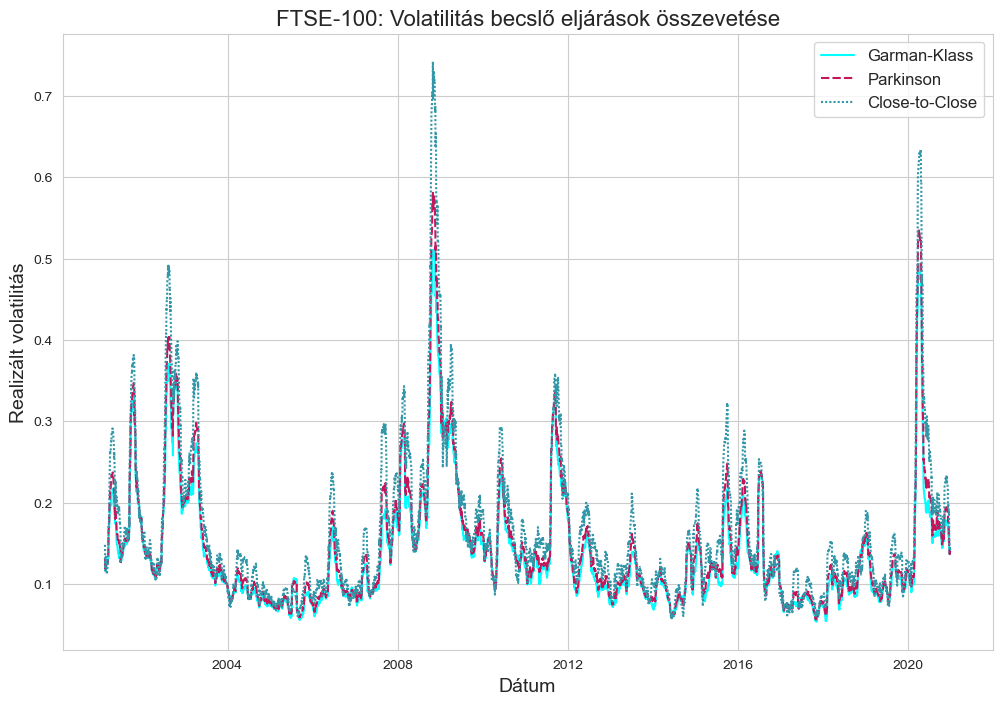

In [10]:
gk_vol = UKX['gk_vola']
pk_vol = UKX['parkinson_vola']
sd_vol =UKX['sd_vola']

vol_data = pd.DataFrame({'Garman-Klass': gk_vol, 'Parkinson': pk_vol, 'Close-to-Close': sd_vol})

sns.set_palette("crest")
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=vol_data, ax=ax, palette=['cyan', '#c2185b', '#3297a8'])
ax.set_xlabel('Dátum', size=14)
ax.set_ylabel('Realizált volatilitás', size=14)
ax.set_title('FTSE-100: Volatilitás becslő eljárások összevetése', size=16)
ax.legend(fontsize=12)
plt.show()


### Expand data with control variables. 
Contains the European Sentiment Indicator(eventually not used)/CNN Money Fear & Greed Index to represent the investor sentiment, the Bank of England and the European Central Bank rating decision history (dummies) to represent the monetary policy shocks, CBOE VIX index to represent the US-market volatility. The Fear & Greed Index is only available from 2011, therefore it should be treated separately. 

In [15]:
c=pd.read_excel('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Control/ESI_ECB.xlsx')
#contains the European Sentiment Indicator, the BoE and the ECB rating decision history (dummies)
vix=yf.download("^VIX", start="2002-01-01", end="2019-12-31") #proxy of the global volatility in the model. 
vix=vix.reset_index()
vix=vix[['Date','Adj Close']]
vix=vix.rename(columns={'Adj Close':'VIX'})
# fg=pd.read_csv('/Users/horvathbalint/Documents/Pénzügy_MSc/Szakdolgozat/Adatok/Control/fear-greed.csv')
# fg=fg[['Date','Fear Greed']]
# fg['Date'] = pd.to_datetime(fg['Date'])

[*********************100%***********************]  1 of 1 completed


In [16]:
DAX=pd.merge(DAX, vix, on="Date", how="left")
DAX=pd.merge(DAX, c, on="Date", how="left")
# DAX=pd.merge(DAX, fg, on="Date", how="left")
DAX['VIX'] = DAX['VIX'].fillna(DAX['VIX'].rolling(window=21, min_periods=1).mean())

SMI=pd.merge(SMI, vix, on="Date", how="left")
SMI=pd.merge(SMI, c, on="Date", how="left")
# SMI=pd.merge(SMI, fg, on="Date", how="left")
SMI['VIX'] = SMI['VIX'].fillna(SMI['VIX'].rolling(window=21, min_periods=1).mean())

UKX=pd.merge(UKX, vix, on="Date", how="left")
UKX=pd.merge(UKX, c, on="Date", how="left")
# UKX=pd.merge(UKX, fg, on="Date", how="left")
UKX['VIX'] = UKX['VIX'].fillna(UKX['VIX'].rolling(window=21, min_periods=1).mean())

BEL20=pd.merge(BEL20, vix, on="Date", how="left")
BEL20=pd.merge(BEL20, c, on="Date", how="left")
# BEL20=pd.merge(BEL20, fg, on="Date", how="left")
BEL20['VIX'] = BEL20['VIX'].fillna(BEL20['VIX'].rolling(window=21, min_periods=1).mean())

HEX=pd.merge(HEX, vix, on="Date", how="left")
HEX=pd.merge(HEX, c, on="Date", how="left")
# HEX=pd.merge(HEX, fg, on="Date", how="left")
HEX['VIX'] = HEX['VIX'].fillna(HEX['VIX'].rolling(window=21, min_periods=1).mean())

### Option market data. 
Data source: OptionMetrics OptionIvy Europe DB. The original file was a large sas7bdat database. The input pq. files are the results of the sasdata_read_in.py code and are already filtered per Security ID, containing the following indices: AEX (no results), CAC (too messy, too much missing values --> unusable), DAX, HEX, UKX (FTSE-100), BEL20, SMI. 

Please note, that the following code snippet runs for a several minutes. As a shortcut I preferred to call it as a pre-saved pq. file: optionprice_final.parq

In [ ]:
directory = "/Users/horvathbalint/Data/Options/Raw_PQ"
file_paths = []

for filename in os.listdir(directory):
    if filename.endswith(".parquet"):
        path = os.path.join(directory, filename)
        file_paths.append(path)

dfs = []
for path in file_paths:
    df = pd.read_parquet(path)
    dfs.append(df)

df = pd.concat(dfs)

opt=pd.read_parquet('/Users/horvathbalint/Data/Options/Medium/OptionID.parq')

df['Date']=pd.to_timedelta(df['Date'], unit='D')+pd.Timestamp('1960-1-1')
df=df.drop(['Currency' , 'Bid' , 'BidTime' , 'UnderlyingBid' , 'Ask' , 
            'AskTime' , 'UnderlyingAsk' , 'Vega' , 'Theta' , 'Last' , 
            'LastTime' , 'ReferenceExchange', 'CalculationPrice'], axis=1, inplace=False)

"""Implied volatility and the greeks was set to -99.99 if IV calculation fails to 
converge or if the option is a "special settlement" or the midpoint of the
bid/ask price is below instrinic value. """

df = df[~np.isclose(df['ImpliedVolatility'], -99.989998, rtol=1e-5)]

"""We are looking for these 7 European stock indices: """
def get_symbol(SecurityID):
    if SecurityID == 501271.0:
        return 'AEX'
    elif SecurityID==506496.0:
        return 'DAX'
    elif SecurityID==508037.0:
        return 'CAC'
    elif SecurityID==506522.0 or SecurityID==707745.0:
        return 'SMI'
    elif SecurityID==510399.0:
        return 'HEX'
    elif SecurityID==506528.0:
        return 'UKX'
    elif SecurityID==506552.0:
        return 'BEL20'
    else:
        return 'NA'
    
df = df.reset_index()
df['Ticker'] = df['SecurityID'].apply(get_symbol)

"""Input contract size from the OptionHistory file"""
merged_df = pd.merge(df, opt, on='OptionID', how='left')
df=merged_df.drop(['index','SecurityID_y', 'Strike', 'CallPut', 'OptionStyle', 'ExerciseStyle', 'Expiration'], axis=1, inplace=False)

"""Calculating Gamma exposure based on SqueezeMetrics Research and Sergei Perfiliev"""
get_call_put = lambda x: 1 if x['Delta'] > 0 else -1
df['CallPut'] = df.apply(get_call_put, axis=1)

df['GEX']=df['Gamma']*df['OpenInterest']*df['ContractSize']*df['UnderlyingLast']*df['CallPut']
df=df.groupby(['Date', 'Ticker'])[['GEX', 'Volume']].sum() 

In [ ]:
write('/Users/horvathbalint/Data/Options/Medium/optionprice_final.parq', df)

In [17]:
df=pd.read_parquet('/Users/horvathbalint/Data/Options/Medium//optionprice_final.parq')
df=df.rename(columns={'Volume':'OptVolume'})

In [18]:
df.head(5)

GEX  OptVolume
Date       Ticker                         
2002-01-02 BEL20   4.891859e+05      173.0
           DAX     2.691270e+06    84528.0
           HEX    -6.223139e+05      909.0
           SMI    -7.672630e+05     7036.0
           UKX     2.065472e+06    36265.0

In [19]:
df.tail(5)

GEX  OptVolume
Date       Ticker                         
2019-12-30 UKX     1.123094e+07    10401.0
2019-12-31 BEL20   0.000000e+00        0.0
           HEX    -4.177303e+06      373.0
           SMI    -1.220655e+04        0.0
           UKX     9.557184e+06     5196.0

### Merging the option market data and the underlying market data. Handling missing values. 

In [20]:
df_dax = df.loc[(slice(None), 'DAX'), :]
DAX=pd.merge(DAX, df_dax, on="Date", how="left")
DAX['O/S']=DAX['OptVolume']/DAX['Volume']
DAX['gamma_proxy']=DAX['GEX']/DAX['mavg_volume']
DAX = DAX.loc[(DAX["Date"] >= "2002-01-01") & (DAX["Date"] <= "2019-12-31")]
mavg=DAX['gamma_proxy'].rolling(window=7, min_periods=1).mean()
DAX['gamma_proxy' ]=DAX['gamma_proxy'].fillna(mavg)
DAX[['sd_vola_252','sd_vola', 'parkinson_vola', 'gk_vola']].fillna(method='ffill')
DAX=DAX.dropna()

###

df_smi=df.loc[(slice(None), 'SMI'), :]
SMI=pd.merge(SMI, df_smi, on="Date", how="left")
SMI['O/S']=SMI['OptVolume']/SMI['Volume']
SMI['gamma_proxy']=SMI['GEX']/SMI['mavg_volume']
SMI = SMI.loc[(SMI["Date"] >= "2002-01-01") & (SMI["Date"] <= "2019-12-31")]
mavg=SMI['gamma_proxy'].rolling(window=7, min_periods=1).mean()
SMI['gamma_proxy' ]=SMI['gamma_proxy'].fillna(mavg)
SMI[['sd_vola_252','sd_vola', 'parkinson_vola', 'gk_vola']].fillna(method='ffill')
SMI=SMI.dropna()


###

df_bel=df.loc[(slice(None), 'BEL20'), :]
BEL20=pd.merge(BEL20, df_bel, on="Date", how="left")
BEL20['O/S']=BEL20['OptVolume']/BEL20['Volume']
BEL20['gamma_proxy']=BEL20['GEX']/BEL20['mavg_volume']
BEL20 = BEL20.loc[(BEL20["Date"] >= "2002-01-01") & (BEL20["Date"] <= "2019-12-31")]
mavg=BEL20['gamma_proxy'].rolling(window=7, min_periods=1).mean()
BEL20['gamma_proxy' ]=BEL20['gamma_proxy'].fillna(mavg)
BEL20[['sd_vola_252','sd_vola', 'parkinson_vola', 'gk_vola']].fillna(method='ffill')
BEL20=BEL20.dropna()

###

df_hex=df.loc[(slice(None), 'HEX'), :]
HEX=pd.merge(HEX, df_hex, on="Date", how="left")
HEX['O/S']=HEX['OptVolume']/HEX['Volume']
HEX['gamma_proxy']=HEX['GEX']/HEX['mavg_volume']
HEX = HEX.loc[(HEX["Date"] >= "2002-01-01") & (HEX["Date"] <= "2019-12-31")]
mavg=HEX['gamma_proxy'].rolling(window=7, min_periods=1).mean()
HEX['gamma_proxy' ]=HEX['gamma_proxy'].fillna(mavg)
HEX[['sd_vola', 'parkinson_vola', 'gk_vola']].fillna(method='ffill')
HEX=HEX.dropna()

###

df_ukx=df.loc[(slice(None), 'UKX'), :]
UKX=pd.merge(UKX, df_ukx, on="Date", how="left")
UKX['O/S']=UKX['OptVolume']/UKX['Volume']
UKX['gamma_proxy']=UKX['GEX']/UKX['mavg_volume']
UKX = UKX.loc[(UKX["Date"] >= "2002-01-01") & (UKX["Date"] <= "2019-12-31")]
mavg=UKX['gamma_proxy'].rolling(window=7, min_periods=1).mean()
UKX['gamma_proxy' ]=UKX['gamma_proxy'].fillna(mavg)
UKX[[ 'sd_vola', 'parkinson_vola', 'gk_vola']].fillna(method='ffill')
UKX=UKX.dropna()

del df_bel, df_dax, df_smi, df_ukx, df_hex, mavg, df

## Descriptive stats

In [21]:
DAX[['gamma_proxy', 'log_ret', 'gk_vola']].describe().T

,count,mean,std,min,25%,50%,75%,max
gamma_proxy,4448.0,0.020197,0.077138,-0.202202,-0.035100,0.014964,0.067704,0.354392
log_ret,4448.0,0.000177,0.014311,-0.073355,-0.006307,0.000791,0.007026,0.107975
gk_vola,4448.0,0.165404,0.089970,0.055508,0.106237,0.138013,0.189720,0.589908


In [22]:
HEX[['gamma_proxy', 'log_ret', 'gk_vola']].describe().T

,count,mean,std,min,25%,50%,75%,max
gamma_proxy,4156.0,0.016740,0.073525,-0.336994,-0.017274,0.005572,0.052078,1.062708
log_ret,4156.0,-0.000066,0.014489,-0.092318,-0.007164,0.000521,0.007336,0.088500
gk_vola,4156.0,0.157334,0.082114,0.050573,0.100748,0.129202,0.191553,0.534744


In [23]:
SMI[['gamma_proxy', 'log_ret', 'gk_vola']].describe().T

,count,mean,std,min,25%,50%,75%,max
gamma_proxy,4414.0,-0.016366,0.048944,-0.295075,-0.041526,-0.014294,0.013224,0.136786
log_ret,4414.0,0.000178,0.010720,-0.066998,-0.004910,0.000505,0.005548,0.094504
gk_vola,4414.0,0.124579,0.067391,0.049922,0.084434,0.100131,0.136598,0.435479


In [24]:
UKX[['gamma_proxy', 'log_ret',  'gk_vola']].describe().T

,count,mean,std,min,25%,50%,75%,max
gamma_proxy,4480.0,0.002664,0.011518,-0.038781,-0.003549,0.001383,0.008099,0.075410
log_ret,4480.0,0.000086,0.011381,-0.092656,-0.005073,0.000413,0.005646,0.093843
gk_vola,4480.0,0.132924,0.069296,0.053631,0.087959,0.110278,0.151784,0.511452


In [25]:
BEL20[['gamma_proxy', 'log_ret', 'gk_vola']].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gamma_proxy,4339.0,0.005375,0.066032,-0.460256,-0.000060,0.000000,0.000053,0.780373
log_ret,4339.0,0.000015,0.012328,-0.083193,-0.005590,0.000337,0.006159,0.093340
gk_vola,4339.0,0.128375,0.062049,0.053168,0.087232,0.110385,0.149046,0.463191


## Plots, serial autocorrelation

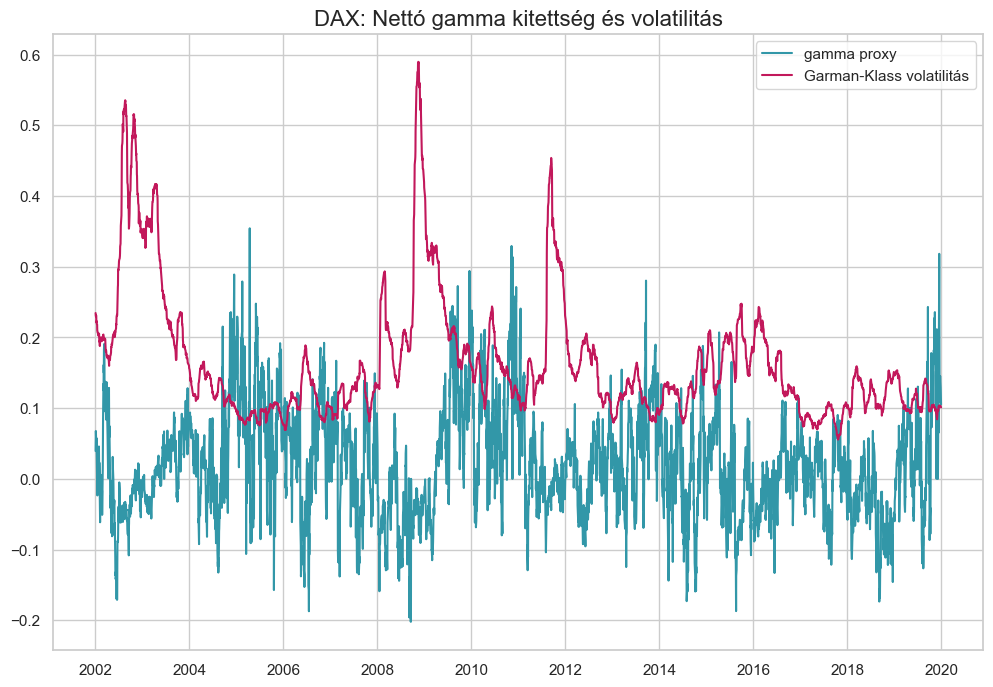

In [26]:
sns.set(style='whitegrid', palette=['#3297a8', '#c2185b'])
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='Date', y='gamma_proxy', data=DAX, label='gamma proxy', ax=ax)
sns.lineplot(x='Date', y='gk_vola', data=DAX, label='Garman-Klass volatilitás', ax=ax)
plt.title('DAX: Nettó gamma kitettség és volatilitás', size=16)
plt.legend()
plt.gca().set(xlabel='', ylabel='')
plt.show()

### Volatility and gamma proxy has serial autocorrelation.

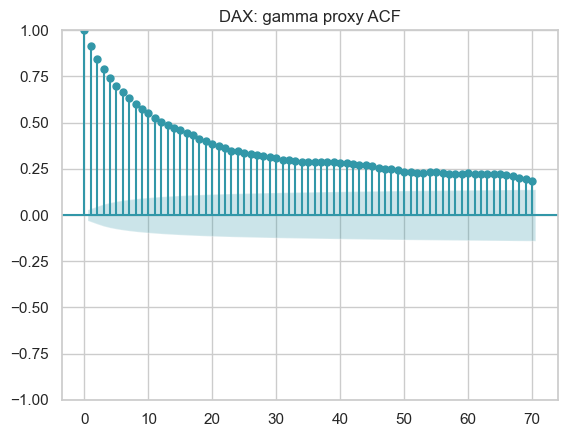

In [31]:
plot_acf(DAX['gamma_proxy'], lags=70)
plt.title('DAX: gamma proxy ACF')
plt.show()

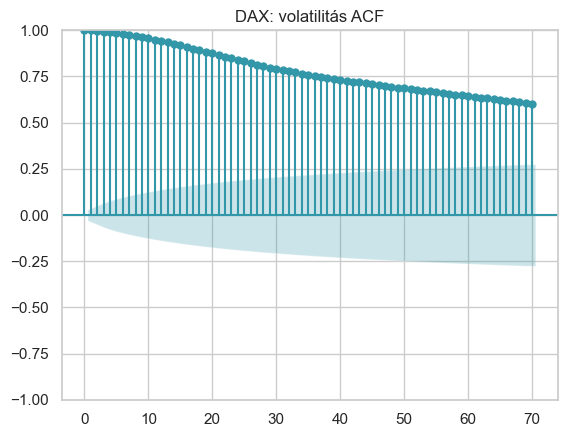

In [32]:
plot_acf(DAX['gk_vola'], lags=70)
plt.title('DAX: volatilitás ACF')
plt.show()

/Users/horvathbalint/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


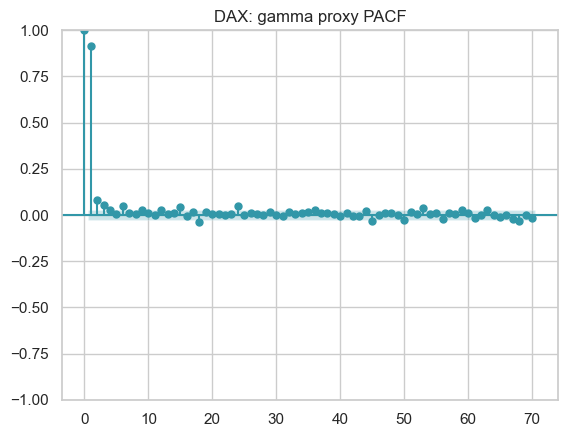

In [33]:
plot_pacf(DAX['gamma_proxy'], lags=70)
plt.title('DAX: gamma proxy PACF')
plt.show()

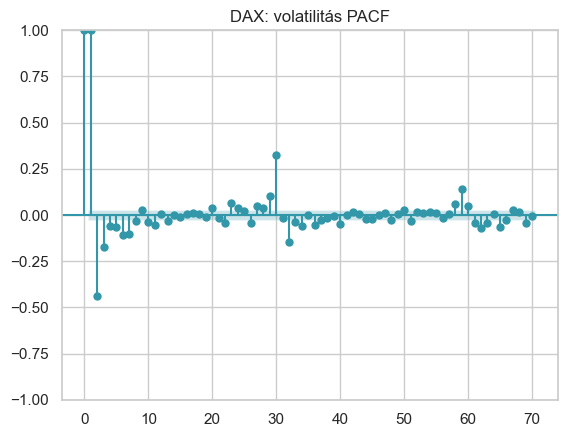

In [34]:
plot_pacf(DAX['gk_vola'], lags=70)
plt.title('DAX: volatilitás PACF')
plt.show()

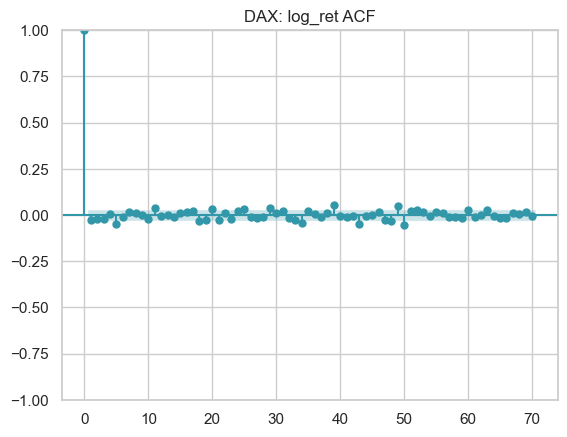

In [37]:
plot_acf(DAX['log_ret'], lags=70)
plt.title('DAX: log_ret ACF')
plt.show()

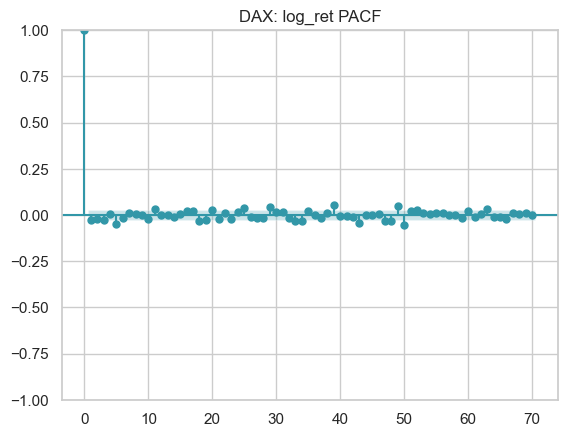

In [36]:
plot_pacf(DAX['log_ret'], lags=70)
plt.title('DAX: log_ret PACF')
plt.show()

## Test for unit root, covariance stationarity. 

In [38]:
print(PhillipsPerron(DAX["gamma_proxy"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(DAX["gamma_proxy"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(DAX["gamma_proxy"], lags=32, test_type="rho", trend="ct"))

     Phillips-Perron Test (Z-rho)    
Test Statistic               -398.198
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.23 (1%), -7.78 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -433.763
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -438.770
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.30 (1%),

gamma_proxy is weakly stationary.

In [39]:
print(PhillipsPerron(DAX["gk_vola"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(DAX["gk_vola"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(DAX["gk_vola"], lags=32, test_type="rho", trend="ct"))

     Phillips-Perron Test (Z-rho)    
Test Statistic                 -7.598
P-value                         0.054
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.23 (1%), -7.78 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                -30.620
P-value                         0.001
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                -34.712
P-value                         0.003
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.30 (1%),

volatility - Phillips-Perron test statistic (with no trend) -7.598 --> Hits the 5% critical value. Potentially problematic, existence of unit root. 

In [40]:
print(PhillipsPerron(DAX["log_ret"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(DAX["log_ret"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(DAX["log_ret"], lags=32, test_type="rho", trend="ct"))

     Phillips-Perron Test (Z-rho)    
Test Statistic              -4311.000
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.23 (1%), -7.78 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic              -4300.844
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic              -4293.319
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.30 (1%),

log ret OK

## Time Series Regression
Using Newey-White standard errors (heteroscedasticity and autocorrelation robust.)

instead of volatility, I use delta volatility bc. of the potential unit root and the strong serial autocorrelation

In [41]:
DAX['d_gk_vola']=DAX['gk_vola']-DAX['gk_vola'].shift(1)
DAX['d_gk_vola']=DAX['d_gk_vola'].fillna(method='bfill')

In [42]:
print(PhillipsPerron(DAX["d_gk_vola"], lags=32, test_type="rho", trend="n"))

     Phillips-Perron Test (Z-rho)    
Test Statistic              -4988.161
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.23 (1%), -7.78 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


unit-root problem fixed. 

In [43]:
reg1=(smf.ols("d_gk_vola ~ gamma_proxy", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_gk_vola   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     36.81
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.41e-09
Time:                        19:56:09   Log-Likelihood:                 17714.
No. Observations:                4448   AIC:                        -3.542e+04
Df Residuals:                    4446   BIC:                        -3.541e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0002      0.000      1.085      0.278      -0.000       0.001
gamma_proxy    -0.0111      0.002     -6.067      0.000      -0.015      -0.008
==============================================================================
Omnibus:                     2480.554   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313343.289
Skew:                           1.675   Prob(JB):                         0.00
Kurtosis:                      43.981   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

Let's try lagged independent variable. 

In [44]:
DAX['gamma_lag']=DAX['gamma_proxy'].shift(1)

In [45]:
reg2=(smf.ols("d_gk_vola ~ gamma_lag", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_gk_vola   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     28.42
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.02e-07
Time:                        19:56:51   Log-Likelihood:                 17695.
No. Observations:                4447   AIC:                        -3.539e+04
Df Residuals:                    4445   BIC:                        -3.537e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.961      0.337      -0.000       0.001
gamma_lag     -0.0100      0.002     -5.331      0.000      -0.014      -0.006
==============================================================================
Omnibus:                     2491.545   Durbin-Watson:                   1.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           306978.416
Skew:                           1.696   Prob(JB):                         0.00
Kurtosis:                      43.561   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

Lower R squared. 

### Testing alternative volatility measures. 

In [46]:
DAX['d_sd_vola']=DAX['sd_vola']-DAX['sd_vola'].shift(1)
DAX['d_parkinson_vola']=DAX['parkinson_vola']-DAX['parkinson_vola'].shift(1)
DAX['abs_log_ret']=np.abs(DAX['log_ret'])

In [47]:
reg3=(smf.ols("d_sd_vola ~ gamma_proxy", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_sd_vola   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     38.54
Date:                Mon, 08 May 2023   Prob (F-statistic):           5.85e-10
Time:                        19:58:33   Log-Likelihood:                 14599.
No. Observations:                4447   AIC:                        -2.919e+04
Df Residuals:                    4445   BIC:                        -2.918e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0003      0.000      1.120      0.263      -0.000       0.001
gamma_proxy    -0.0150      0.002     -6.208      0.000      -0.020      -0.010
==============================================================================
Omnibus:                     1360.081   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124698.792
Skew:                           0.467   Prob(JB):                         0.00
Kurtosis:                      28.925   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

In [48]:
reg4=(smf.ols("d_parkinson_vola ~ gamma_proxy", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       d_parkinson_vola   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     38.15
Date:                Mon, 08 May 2023   Prob (F-statistic):           7.14e-10
Time:                        19:58:40   Log-Likelihood:                 17500.
No. Observations:                4447   AIC:                        -3.500e+04
Df Residuals:                    4445   BIC:                        -3.498e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0002      0.000      1.093      0.274      -0.000       0.001
gamma_proxy    -0.0116      0.002     -6.176      0.000      -0.015      -0.008
==============================================================================
Omnibus:                     2325.809   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           264673.952
Skew:                           1.525   Prob(JB):                         0.00
Kurtosis:                      40.671   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

In [49]:
reg5=(smf.ols("log_ret ~ gamma_proxy", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     177.1
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.21e-39
Time:                        19:59:02   Log-Likelihood:                 12689.
No. Observations:                4448   AIC:                        -2.537e+04
Df Residuals:                    4446   BIC:                        -2.536e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0006      0.000     -3.225      0.001      -0.001      -0.000
gamma_proxy     0.0409      0.003     13.306      0.000       0.035       0.047
==============================================================================
Omnibus:                      633.919   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6047.168
Skew:                           0.359   Prob(JB):                         0.00
Kurtosis:                       8.667   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

In [50]:
reg6=(smf.ols("log_ret ~ gamma_lag", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.002033
Date:                Mon, 08 May 2023   Prob (F-statistic):              0.964
Time:                        19:59:08   Log-Likelihood:                 12575.
No. Observations:                4447   AIC:                        -2.515e+04
Df Residuals:                    4445   BIC:                        -2.513e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.771      0.440      -0.000       0.001
gamma_lag      0.0001      0.002      0.045      0.964      -0.004       0.005
==============================================================================
Omnibus:                      499.388   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4731.798
Skew:                           0.031   Prob(JB):                         0.00
Kurtosis:                       8.053   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

In [51]:
reg7=(smf.ols("d_gk_vola ~ gamma_proxy+gamma_lag", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_gk_vola   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     27.38
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.52e-12
Time:                        19:59:28   Log-Likelihood:                 17709.
No. Observations:                4447   AIC:                        -3.541e+04
Df Residuals:                    4444   BIC:                        -3.539e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0002      0.000      1.072      0.284      -0.000       0.001
gamma_proxy    -0.0117      0.002     -6.508      0.000      -0.015      -0.008
gamma_lag       0.0007      0.002      0.314      0.754      -0.003       0.005
==============================================================================
Omnibus:                     2481.091   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313388.332
Skew:                           1.677   Prob(JB):                         0.00
Kurtosis:                      43.989   Cond. No.                         43.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

## gamma proxy is highly significant in the volatility models. best fit: Garman-Klass volatility. 

In [52]:
print(adfuller(DAX['abs_log_ret']))

(-5.264570667305787, 6.480959805891503e-06, 27, 4420, {'1%': -3.431830339774537, '5%': -2.862194131214493, '10%': -2.56711819808153}, -29024.32520303486)


In [53]:
print(PhillipsPerron(DAX["abs_log_ret"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(DAX["abs_log_ret"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(DAX["abs_log_ret"], lags=32, test_type="rho", trend="ct"))

     Phillips-Perron Test (Z-rho)    
Test Statistic              -7937.675
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.23 (1%), -7.78 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic             -13804.415
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic             -13615.950
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.30 (1%),

abs_log_ret is OK. 

In [54]:
reg9=(smf.ols("abs_log_ret ~ gamma_lag", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            abs_log_ret   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     57.97
Date:                Mon, 08 May 2023   Prob (F-statistic):           3.23e-14
Time:                        20:01:29   Log-Likelihood:                 14177.
No. Observations:                4447   AIC:                        -2.835e+04
Df Residuals:                    4445   BIC:                        -2.834e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0106      0.000     21.724      0.000       0.010       0.012
gamma_lag     -0.0344      0.005     -7.614      0.000      -0.043      -0.026
==============================================================================
Omnibus:                     2423.478   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24598.832
Skew:                           2.415   Prob(JB):                         0.00
Kurtosis:                      13.460   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

## Better than Garman-Klass volatility. Regression coefficients are negative as expected, and significant at any significance levels, with HAC robust SE.-s.

Visualisation of the relationship: 

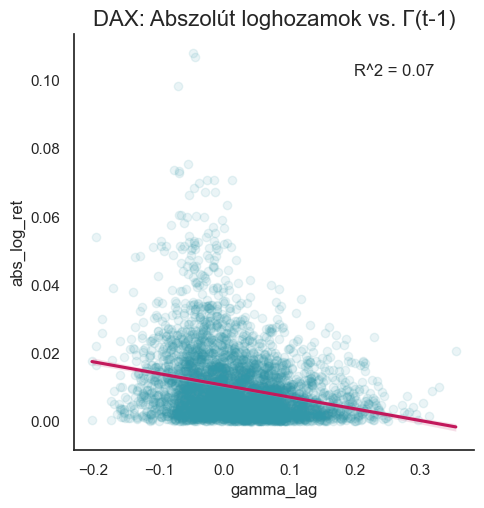

In [55]:
r_squared=reg9.rsquared
sns.set_style("white")
sns.set_palette("crest")
sns.lmplot(x="gamma_lag", y="abs_log_ret", scatter_kws={"alpha":0.1, "color":"#3297a8"}, data=DAX,line_kws={"color":"#c2185b"}, robust=False)
plt.title("DAX: Abszolút loghozamok vs. Γ(t-1)", size=16)
plt.annotate(f"R^2 = {r_squared:.2f}", xy=(0.7, 0.9), xycoords="axes fraction")
plt.show()

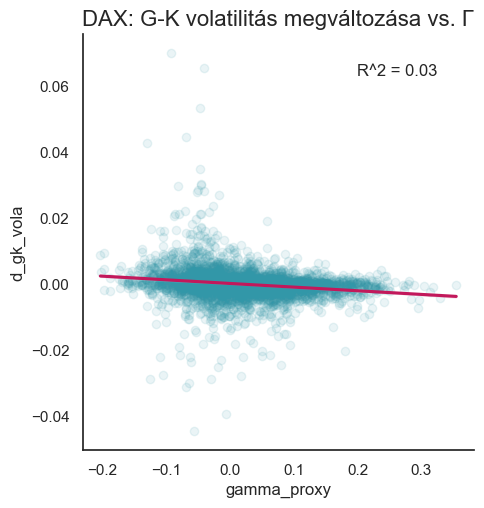

In [56]:
r_squared_2=reg1.rsquared
sns.set_style("white")
sns.set_palette("crest")
sns.lmplot(x="gamma_proxy", y="d_gk_vola", scatter_kws={"alpha":0.1, "color":"#3297a8"}, data=DAX,line_kws={"color":"#c2185b"}, robust=False)
plt.title("DAX: G-K volatilitás megváltozása vs. Γ", size=16)
plt.annotate(f"R^2 = {r_squared_2:.2f}", xy=(0.7, 0.9), xycoords="axes fraction")
plt.show()

## Higher density in the upper-left area - negative gamma-proxy & higher volatility. 

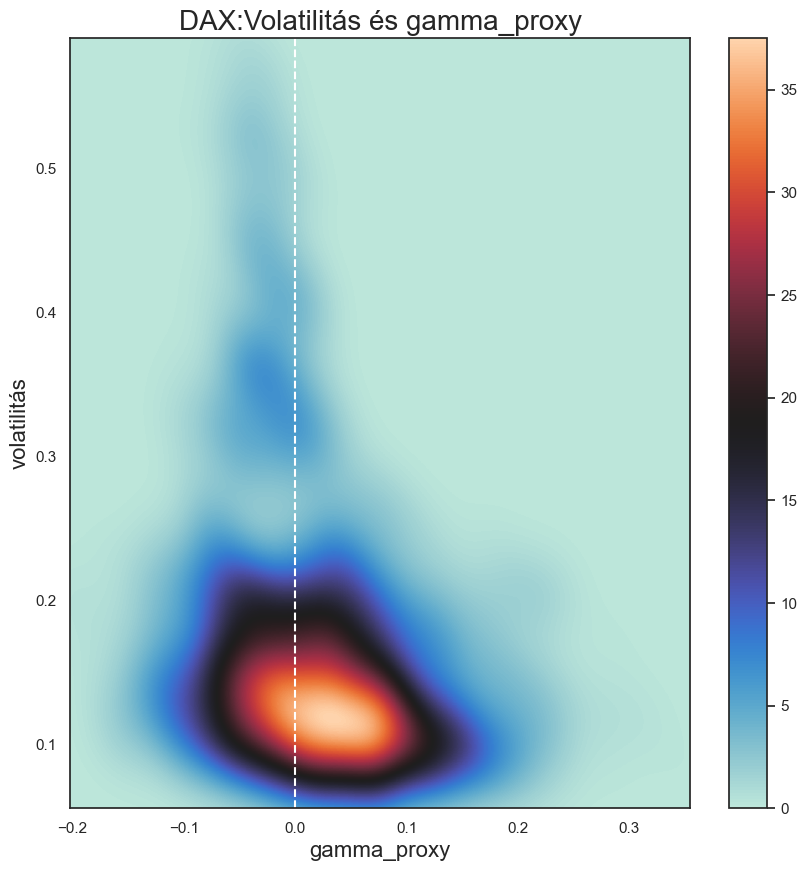

In [58]:
data = np.vstack([DAX['gamma_proxy'], DAX['gk_vola']])
mask = np.isfinite(data).all(axis=0)
data = data[:, mask]

kde = gaussian_kde(data)

xmin, xmax = np.min(data[0]), np.max(data[0])
ymin, ymax = np.min(data[1]), np.max(data[1])


x, y = np.meshgrid(np.linspace(xmin, xmax, 500),
                   np.linspace(ymin, ymax, 500))
z = kde(np.vstack([x.ravel(), y.ravel()]))


z = z.reshape(x.shape)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style('white')
plt.imshow(z, origin='lower', cmap='icefire', extent=[xmin, xmax, ymin, ymax], aspect='auto')
plt.title("DAX:Volatilitás és gamma_proxy", size=20)
plt.xlabel("gamma_proxy", size=16)
plt.ylabel("volatilitás", size=16)
plt.colorbar()
plt.axvline(x=0, color="white", linestyle='--')
plt.show()

checking the residuals

In [59]:
residuals=reg9.resid
print(adfuller(residuals))

(-5.676916734763878, 8.66233782553855e-07, 22, 4424, {'1%': -3.431829000533984, '5%': -2.8621935395791693, '10%': -2.5671178831251695}, -29111.924388252562)


residuals are stationary. 

### preparing the summary regression table with Stargazer

In [60]:
reg1=smf.ols("d_gk_vola ~ gamma_proxy", data=DAX).fit()
reg2=smf.ols("d_gk_vola ~ gamma_lag", data=DAX).fit()
reg3=smf.ols("d_sd_vola ~ gamma_proxy", data=DAX).fit()  
reg4=smf.ols("d_parkinson_vola ~ gamma_proxy", data=DAX).fit()
reg5=smf.ols("log_ret ~ gamma_proxy", data=DAX).fit()
reg6=smf.ols("log_ret ~ gamma_lag", data=DAX).fit()
reg7=smf.ols("d_gk_vola ~ gamma_proxy + gamma_lag", data=DAX).fit() 

In [61]:
stargazer = Stargazer([reg1,reg2,reg3,reg4,reg5,reg6, reg7])
stargazer.covariate_order(["gamma_proxy", "gamma_lag","Intercept"])
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "gamma_proxy": "Γ",
        "gamma_lag":"Γ(t-1)"
    }
)
stargazer.custom_columns(
    [
        "d_gk_vola",
        "d_gk_vola",
        "d_sd_vola",
        "d_parkinson_vola",
        "log_ret",
        "log_ret",
        "d_gk_vola"
    ],
    [1, 1, 1, 1, 1,1,1],
)

In [62]:
stargazer

### standard errors should be fixed manually!  (HAC)

## Robustness test with control variables. 

In [63]:
DAX.head(10)

,Date,Close,Volume,log_ret,sd_vola_252,d_vola_252,mavg_volume,sd_vola,parkinson_vola,gk_vola,...,BOE_Rate,GEX,OptVolume,O/S,gamma_proxy,d_gk_vola,gamma_lag,d_sd_vola,d_parkinson_vola,abs_log_ret
0,2002-01-02,5167.88,42511678,0.001507,0.291367,-0.000804,6.835792e+07,0.260803,0.237806,0.234539,...,0,2.691270e+06,84528.0,0.001988,0.039370,-0.002055,NaN,NaN,NaN,0.001507
1,2002-01-03,5270.29,65333239,0.019623,0.291126,-0.000241,6.752617e+07,0.264844,0.237568,0.232484,...,0,3.814689e+06,166245.0,0.002545,0.056492,-0.002055,0.039370,0.004041,-0.000238,0.019623
2,2002-01-04,5318.73,94411658,0.009149,0.291174,0.000048,6.849031e+07,0.264277,0.235445,0.229903,...,0,4.634911e+06,181373.0,0.001921,0.067673,-0.002582,0.056492,-0.000568,-0.002123,0.009149
3,2002-01-07,5232.22,86157643,-0.016399,0.291589,0.000415,6.947378e+07,0.260570,0.235474,0.231103,...,0,3.324923e+06,207578.0,0.002409,0.047859,0.001200,0.067673,-0.003707,0.000029,0.016399
4,2002-01-08,5236.37,99469685,0.000793,0.291584,-0.000005,7.072890e+07,0.255171,0.227314,0.221619,...,0,3.228661e+06,160284.0,0.001611,0.045648,-0.009484,0.047859,-0.005399,-0.008160,0.000793
5,2002-01-09,5288.21,94940528,0.009851,0.291765,0.000181,7.231658e+07,0.256330,0.227829,0.221403,...,0,4.170756e+06,150275.0,0.001583,0.057674,-0.000216,0.045648,0.001159,0.000515,0.009851
6,2002-01-10,5228.11,74807221,-0.011430,0.291692,-0.000073,7.288219e+07,0.258246,0.229061,0.223117,...,0,3.308983e+06,201698.0,0.002696,0.045402,0.001714,0.057674,0.001916,0.001232,0.011430
7,2002-01-11,5209.97,66987275,-0.003476,0.290755,-0.000936,7.106397e+07,0.258156,0.226447,0.219402,...,0,2.759078e+06,154049.0,0.002300,0.038825,-0.003715,0.045402,-0.000090,-0.002614,0.003476
8,2002-01-14,5065.84,73055265,-0.028054,0.291981,0.001225,6.975276e+07,0.270272,0.229080,0.218247,...,0,-1.044488e+05,246772.0,0.003378,-0.001497,-0.001155,0.038825,0.012116,0.002633,0.028054
9,2002-01-15,5062.04,81533356,-0.000750,0.291918,-0.000062,7.057252e+07,0.268475,0.222299,0.209306,...,0,9.772883e+04,176245.0,0.002162,0.001385,-0.008941,-0.001497,-0.001798,-0.006781,0.000750


In [64]:
DAX = DAX.rename(columns={'O/S': 'O_S'})

In [76]:
DAX[['gamma_proxy', 'VIX', 'Volume', 'ECB_RateHist', 'O_S']].corr()

,gamma_proxy,VIX,Volume,ECB_RateHist,O_S
gamma_proxy,1.000000,-0.301399,-0.216352,-0.019914,0.252698
VIX,-0.301399,1.000000,0.392125,0.085093,0.265720
Volume,-0.216352,0.392125,1.000000,0.068055,-0.000885
ECB_RateHist,-0.019914,0.085093,0.068055,1.000000,0.024292
O_S,0.252698,0.265720,-0.000885,0.024292,1.000000


no confusing multicollinearity

In [65]:
reg10=(smf.ols("d_gk_vola ~ gamma_proxy + EU_ESI + ECB_RateHist + VIX + Volume", data=DAX).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg10.summary()

/Users/horvathbalint/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_gk_vola   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     9.989
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.79e-08
Time:                        20:10:53   Log-Likelihood:                 17913.
No. Observations:                4448   AIC:                        -3.581e+04
Df Residuals:                    4442   BIC:                        -3.578e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0108      0.003     -3.540      0.000      -0.017      -0.005
gamma_proxy     -0.0058      0.002     -3.507      0.000      -0.009      -0.003
EU_ESI        7.149e-05   2.25e-05      3.177      0.002    2.74e-05       0.000
ECB_RateHist     0.0012      0.002      0.711      0.477      -0.002       0.005
VIX            4.38e-05   4.48e-05      0.978      0.328    -4.4e-05       0.000
Volume        2.615e-11   5.77e-12      4.532      0.000    1.48e-11    3.75e-11
==============================================================================
Omnibus:                     1522.156   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           200995.824
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                      35.913   Cond. No.                     2.26e+09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
[2] The condition number is large, 2.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Large conditional number - should be standardised!

In [71]:
DAX_scaled = DAX.copy()

# scale the variables fixing the large condition number
scaler = StandardScaler()

In [72]:
DAX_scaled['d_gk_vola'] = scaler.fit_transform(DAX[['d_gk_vola']])
DAX_scaled['abs_log_ret'] = scaler.fit_transform(DAX[['abs_log_ret']])
DAX_scaled[['gamma_proxy', 'ECB_RateHist', 'VIX', 'Volume', 'gamma_lag', 'O_S']] = scaler.fit_transform(DAX[['gamma_proxy', 'ECB_RateHist', 'VIX', 'Volume', 'gamma_lag', 'O_S']])

In [73]:
reg11=(smf.ols("d_gk_vola ~ gamma_proxy +gamma_lag+ ECB_RateHist + VIX + Volume+O_S", data=DAX_scaled).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_gk_vola   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     14.97
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.97e-17
Time:                        20:12:59   Log-Likelihood:                -6051.2
No. Observations:                4447   AIC:                         1.212e+04
Df Residuals:                    4440   BIC:                         1.216e+04
Df Model:                           6                                         
Covariance Type:                  HAC                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.519e-06      0.033     -0.000      1.000      -0.064       0.064
gamma_proxy     -0.1434      0.034     -4.184      0.000      -0.211      -0.076
gamma_lag       -0.0117      0.032     -0.364      0.716      -0.075       0.051
ECB_RateHist     0.0223      0.034      0.659      0.510      -0.044       0.089
VIX             -0.0400      0.083     -0.482      0.630      -0.203       0.123
Volume           0.2817      0.062      4.518      0.000       0.159       0.404
O_S              0.0678      0.029      2.364      0.018       0.012       0.124
==============================================================================
Omnibus:                     1630.421   Durbin-Watson:                   1.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           202992.161
Skew:                           0.715   Prob(JB):                         0.00
Kurtosis:                      36.068   Cond. No.                         5.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

In [75]:
reg12=(smf.ols("abs_log_ret ~ gamma_proxy+gamma_lag+ ECB_RateHist + VIX + Volume+O_S", data=DAX_scaled).fit().get_robustcov_results(cov_type="HAC",maxlags=32))
reg12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            abs_log_ret   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     61.95
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.61e-74
Time:                        20:13:20   Log-Likelihood:                -5624.3
No. Observations:                4447   AIC:                         1.126e+04
Df Residuals:                    4440   BIC:                         1.131e+04
Df Model:                           6                                         
Covariance Type:                  HAC                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0002      0.026      0.007      0.995      -0.052       0.052
gamma_proxy      0.0168      0.031      0.539      0.590      -0.044       0.078
gamma_lag       -0.1322      0.035     -3.817      0.000      -0.200      -0.064
ECB_RateHist    -0.0102      0.016     -0.646      0.518      -0.041       0.021
VIX              0.3882      0.054      7.211      0.000       0.283       0.494
Volume           0.1485      0.033      4.526      0.000       0.084       0.213
O_S              0.0114      0.017      0.660      0.509      -0.022       0.045
==============================================================================
Omnibus:                     1447.806   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8519.997
Skew:                           1.427   Prob(JB):                         0.00
Kurtosis:                       9.151   Cond. No.                         5.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 32 lags and without small sample correction
"""

## Gamma lag is robust to the control variables. 